<a href="https://colab.research.google.com/github/Syilun/face_people_recognization/blob/master/05face_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 2.7MB/s 


In [3]:
import pickle
import keras
from keras.models import load_model
import cv2
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os
from mtcnn import MTCNN
from pprint import pprint

In [6]:
folder_path = '/content/drive/My Drive/Tibame AI/智揚/week10/face_detection'

In [7]:
# read db
with open(os.path.join(folder_path, 'db.pickle'), 'rb') as file:
    db = pickle.load(file)
embeddings = db['embeddings']
names = db['names']

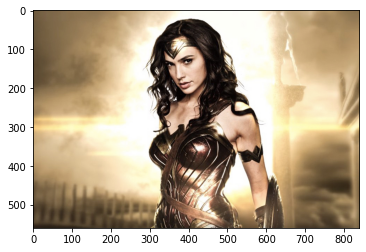

In [8]:
raw_img = cv2.imread(os.path.join(folder_path, 'face1.jpg'))[:,:,::-1]
plt.imshow(raw_img)

In [9]:
detector = MTCNN()
feature_extractor = load_model(os.path.join(folder_path, 'facenet.h5'))

In [10]:
# detect face
def detect_faces(img):
    face_imgs = []
    results = detector.detect_faces(img)
    # extract the bounding box from the first face
    pprint(f'face count: {len(results)}' )
    pprint(results)
    for i in range(len(results)):
        x1, y1, width, height = results[i]['box']
        x2, y2 = x1 + width, y1 + height
        patch = img[y1:y2, x1:x2] # crop face
        face_imgs.append(patch)
    return face_imgs

faces = detect_faces(raw_img)

'face count: 3'
[{'box': [344, 79, 104, 142],
  'confidence': 0.9984662532806396,
  'keypoints': {'left_eye': (353, 139),
                'mouth_left': (370, 192),
                'mouth_right': (408, 184),
                'nose': (369, 174),
                'right_eye': (397, 130)}},
 {'box': [376, 399, 26, 30],
  'confidence': 0.9473416209220886,
  'keypoints': {'left_eye': (387, 408),
                'mouth_left': (384, 420),
                'mouth_right': (389, 421),
                'nose': (391, 416),
                'right_eye': (394, 409)}},
 {'box': [486, 157, 35, 45],
  'confidence': 0.9285461902618408,
  'keypoints': {'left_eye': (501, 172),
                'mouth_left': (504, 190),
                'mouth_right': (517, 190),
                'nose': (514, 180),
                'right_eye': (516, 171)}}]


In [11]:
# all face shapes
for f in faces:
  print(f.shape)

(142, 104, 3)
(30, 26, 3)
(45, 35, 3)


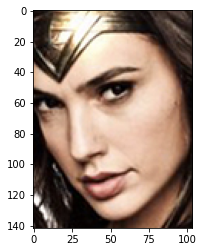

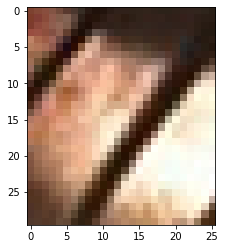

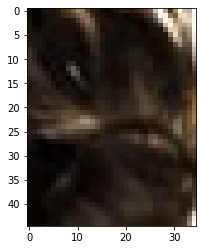

In [12]:
# show all faces
for face in faces:
    plt.imshow(face)
    plt.show()

In [13]:
# Standardization
def preprocess(imgs): 
    for i in range(imgs.shape[0]):
        # standardization
        img = imgs[i]
        mean, std = img.mean(), img.std()
        img = (img - mean) / std
        imgs[i] = img
    return imgs

In [14]:
face = faces[0]
face = cv2.resize(face, (160, 160))
model_input = np.zeros((1, 160, 160, 3))
model_input[0] = face
model_input = preprocess(model_input)
query_embedding = feature_extractor.predict(model_input)

In [15]:
query_embedding = query_embedding[0]
query_embedding

array([-0.02726625,  0.07015379,  1.7289395 ,  0.14948756, -0.2323674 ,
       -0.58820134,  1.3408356 , -1.0932196 , -1.1345406 , -0.07092319,
       -0.8650765 ,  0.00844992, -0.9394938 ,  0.08534457,  1.8212442 ,
       -0.21912377, -3.5643494 ,  0.8206111 , -1.4922252 , -0.18122941,
        0.72842634, -1.8023938 ,  1.6607754 ,  1.0340581 , -0.69084585,
       -0.7869748 , -0.68741226, -1.2972605 ,  0.67302126,  1.9501337 ,
        0.91860354, -0.31722918,  0.27210322,  0.8701639 , -0.5509997 ,
       -1.4732589 ,  1.428047  , -1.5815437 , -0.29689348,  0.06688777,
        0.421953  , -0.24665886, -1.0445201 , -0.3732895 , -0.40785906,
        1.2538847 , -0.02416719,  0.9543699 , -0.5313395 ,  0.7417922 ,
       -0.62439   , -1.1893486 ,  0.5021162 ,  1.0747821 ,  0.85778654,
        0.8327026 , -0.5039285 ,  0.57611805,  0.38940117,  1.371036  ,
       -0.5599001 ,  0.30376667,  0.02549383, -0.5452882 , -0.9571355 ,
        0.8974448 , -1.0879259 ,  1.3537676 ,  0.8697085 ,  0.50

In [16]:
def euclidean_distance(x, y):
    sum_square = np.sum(np.square(x - y), keepdims=True)
    return np.sqrt(sum_square)

In [17]:
# Get all distances from database embeddings 
distances = np.zeros((len(embeddings)))
for i, embed in enumerate(embeddings):
    distance = euclidean_distance(embed, query_embedding)
    distances[i] = distance

[ 8.44371223 14.30239201 15.77602959 15.7924757  14.5178833 ]


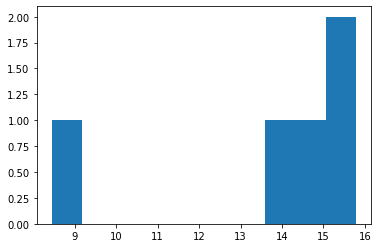

In [18]:
print(distances[:10])
plt.hist(distances)
plt.show()

In [19]:
np.argmin(distances)

0

In [20]:
idx_min = np.argmin(distances)
distances[idx_min], names[idx_min]

(8.44371223449707, 'gal_gadot')

In [21]:
def face_id(filename, IMG_SIZE=160):
    raw_img = cv2.imread(os.path.join(folder_path, filename))[:,:,::-1]
    faces = detect_faces(raw_img)
    if len(faces) == 0:
        print('No face')
        return
    else:
        # get face embeddings
        face = faces[0]


        face = cv2.resize(face, (IMG_SIZE, IMG_SIZE))
        model_input = np.zeros((1, IMG_SIZE, IMG_SIZE, 3))
        model_input[0] = face
        model_input = preprocess(model_input)
        query_embeddings = feature_extractor.predict(model_input)
        query_embedding = query_embeddings[0]
        
        # compute distance
        distances = np.zeros((len(embeddings)))
        for i, embed in enumerate(embeddings):
            distance = euclidean_distance(embed, query_embedding)
            distances[i] = distance
        plt.hist(distances)
        plt.show()
        # find min distance    
        idx_min = np.argmin(distances)
        distance, name = distances[idx_min], names[idx_min]
        print(name, distance)
        plt.imshow(raw_img)
        plt.show()

'face count: 1'
[{'box': [454, 173, 571, 747],
  'confidence': 0.9999363422393799,
  'keypoints': {'left_eye': (623, 480),
                'mouth_left': (659, 766),
                'mouth_right': (876, 739),
                'nose': (755, 614),
                'right_eye': (875, 461)}}]


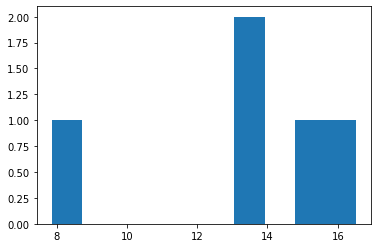

trump 7.86411714553833


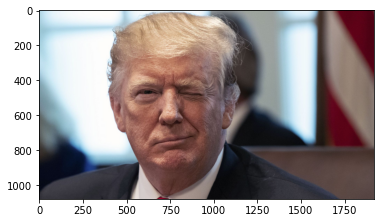

In [26]:
face_id('face2.jpg')